In [2]:
import xarray as xr
from matplotlib.pylab import *
import numpy as np
import pandas as pd
from geopy import distance
from mpl_toolkits.axes_grid1 import make_axes_locatable
from geographiclib.geodesic import Geodesic
import time

import warnings 
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
data = xr.open_dataset('basinSP.nc4')
data

<xarray.Dataset>
Dimensions:   (storm: 178, time: 137)
Coordinates:
  * storm     (storm) int64 599 601 602 603 604 605 ... 772 773 774 775 776 777
  * time      (time) int64 0 1 2 3 4 5 6 7 8 ... 129 130 131 132 133 134 135 136
Data variables:
    latitud   (storm, time) float32 ...
    longitud  (storm, time) float32 ...
    presion   (storm, time) float32 ...
    fechas    (storm, time) datetime64[ns] ...

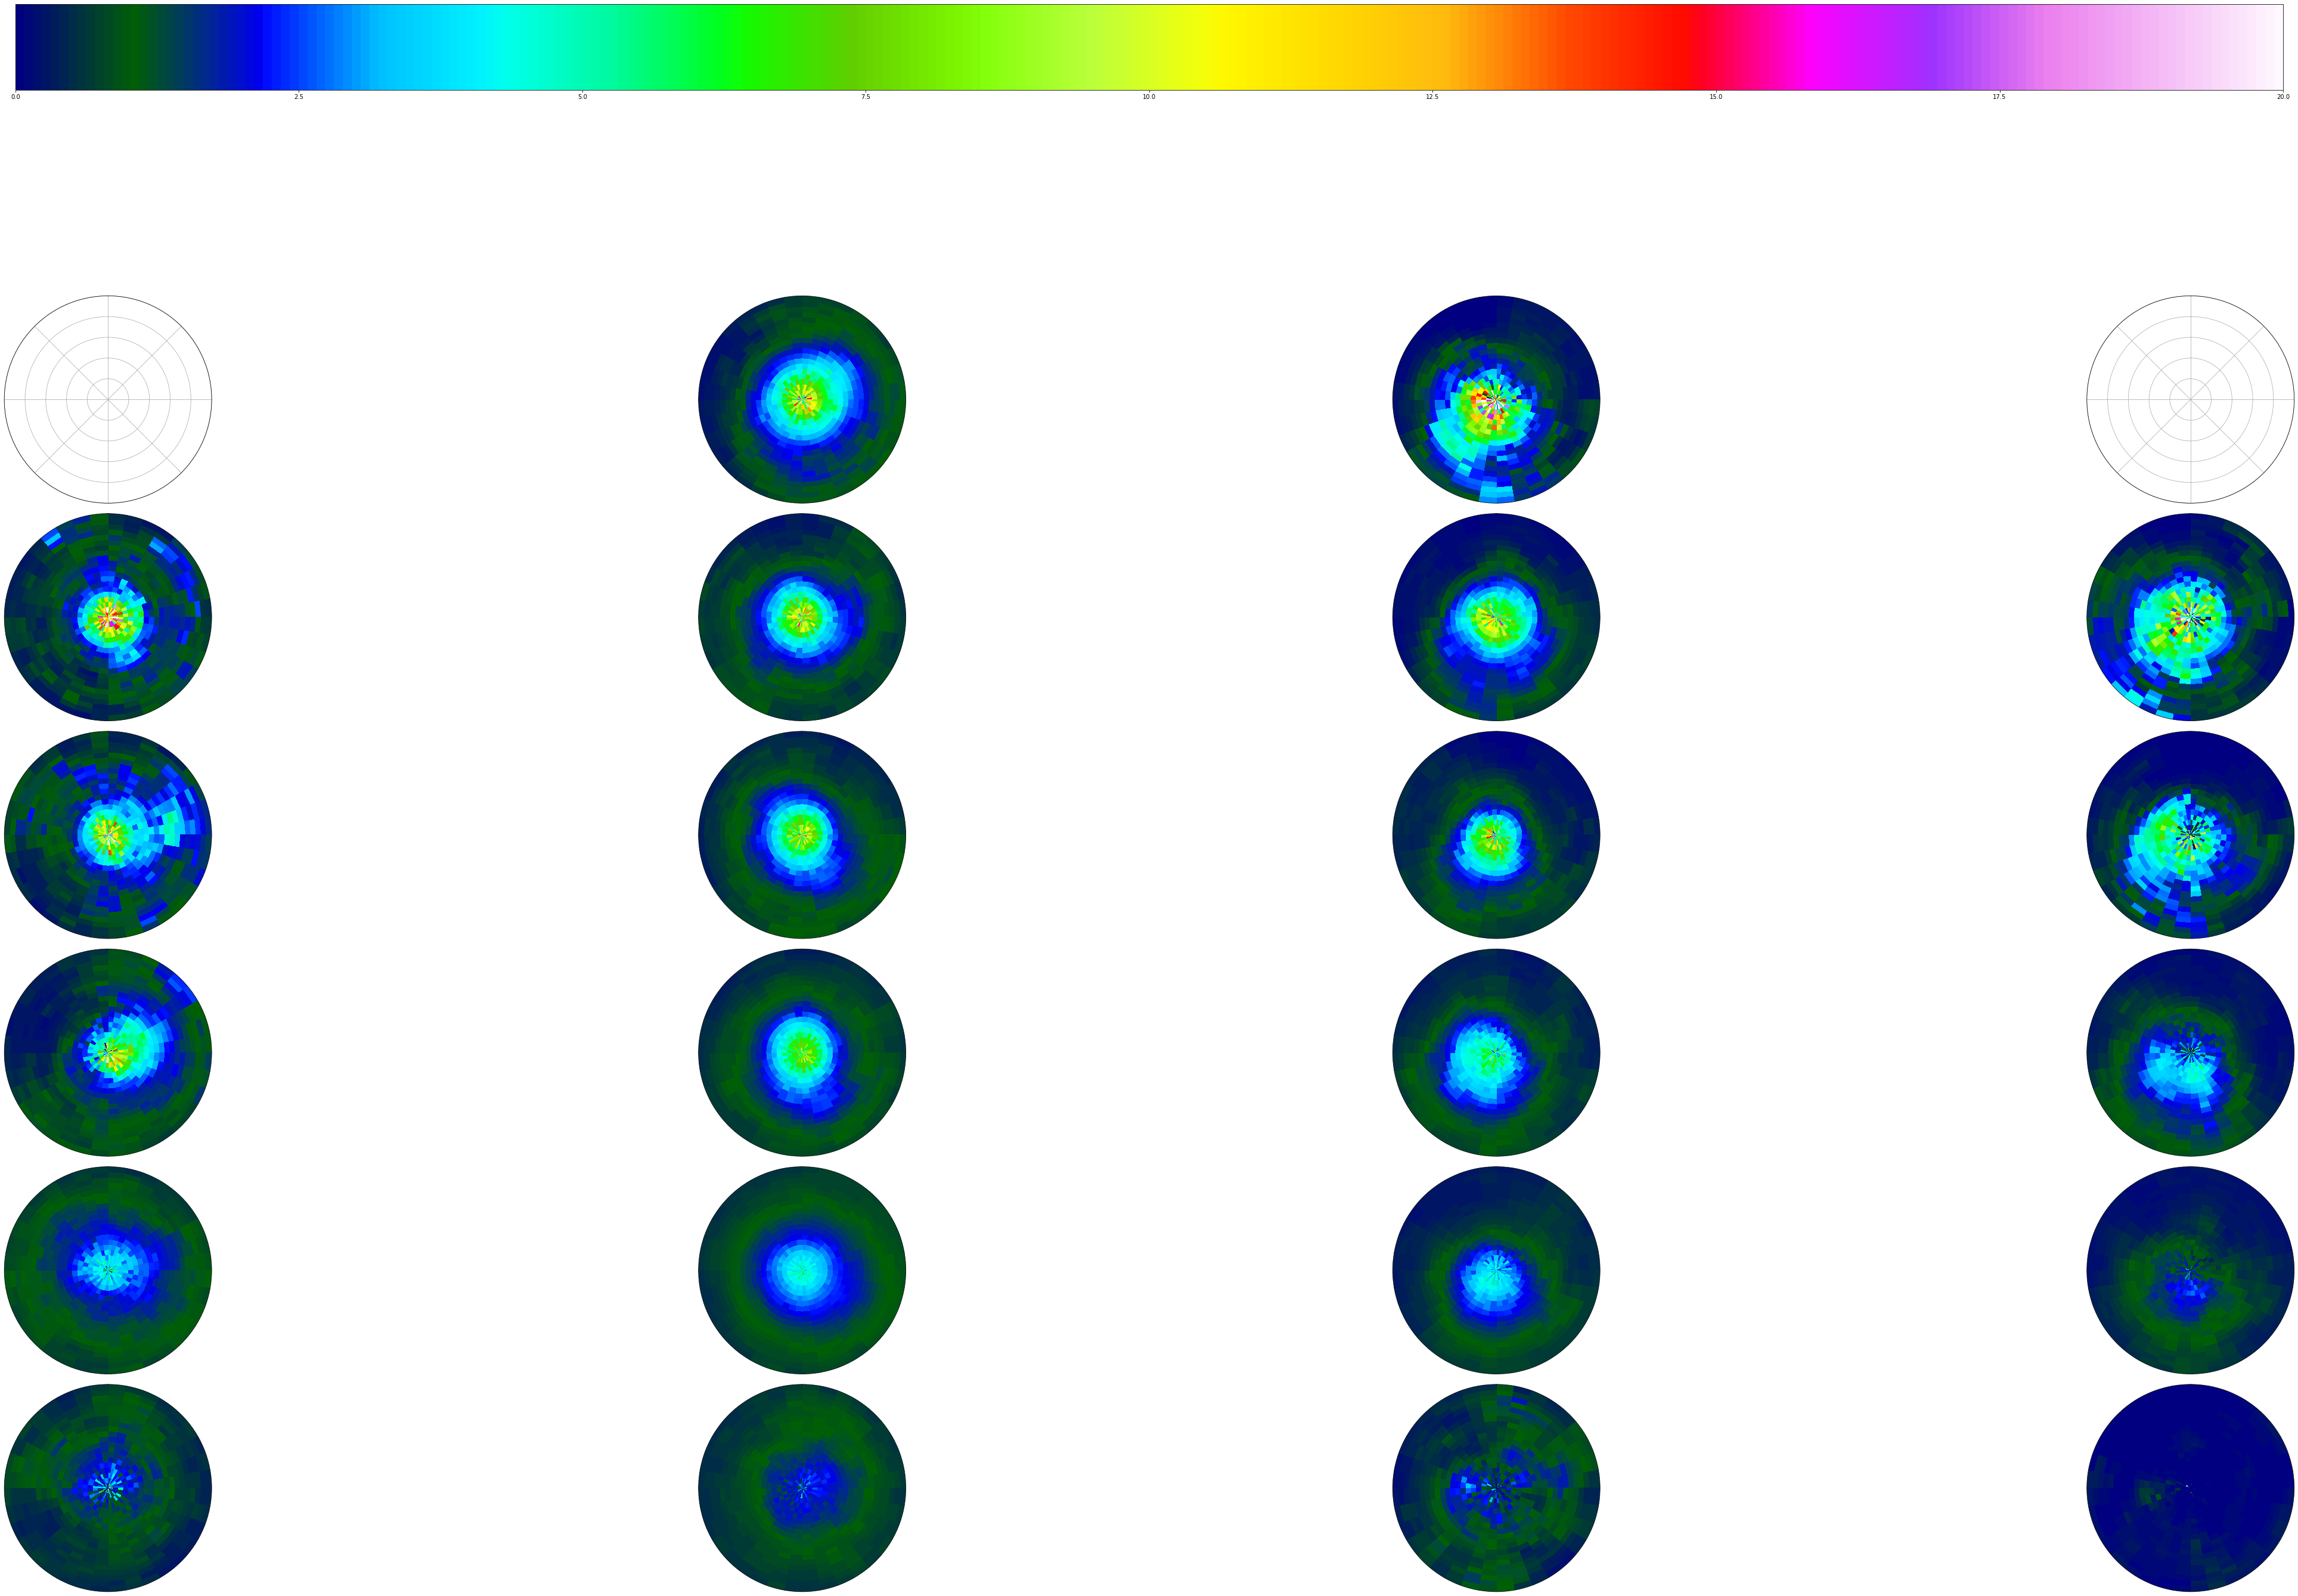

--- 428.8991982936859 seconds ---


In [4]:
start_time = time.time()


#creación del mesh discretizado que quiero
th = np.array(range(0,370,10)) #discretización de ángulos
radius = np.array(range(0,525,25)) #discretización de radios
r, theta = np.meshgrid(radius,th) #mesh de r y theta

sst_discret = [[32,30],[30,28],[28,26],[26,24]]
pres_discret = [[0,920],[920,940],[940,960],[960,980],[980,1000],[1000,1200]]

#creamos fig,axs

fig, axes = plt.subplots(len(pres_discret), len(sst_discret), figsize=(80,40), subplot_kw=dict(polar=True))



cells_obs = []

cells_data = []

for u in range(0,len(pres_discret)):
    for v in range(0,len(sst_discret)):
        
        total_obs = []

        total_idx = []
#comenzamos haciendo un bucle para cada storm
        for t in range(0,len(data.storm)):
            storm = xr.open_dataset('SP_cyclones/ciclonsp'+str(t)+'.nc4') #seleccionamos la storm que corresponde en cada bucle
        
            mask = np.where((pd.to_datetime(storm.time.values).strftime('%H') != '00') & (pd.to_datetime(storm.time.values).strftime('%H') !='03') &
                (pd.to_datetime(storm.time.values).strftime('%H') != '06') & (pd.to_datetime(storm.time.values).strftime('%H') !='09') &
                (pd.to_datetime(storm.time.values).strftime('%H') != '12') & (pd.to_datetime(storm.time.values).strftime('%H') !='15') &
                (pd.to_datetime(storm.time.values).strftime('%H') != '18') & (pd.to_datetime(storm.time.values).strftime('%H') !='21') )
    
    
    
            storm_pres = np.array(np.delete(storm.minPressure.values, np.append(np.where(np.abs(storm.latitude) > 49.875), mask), axis = 0)[:-1])
            storm_lat = np.array(np.delete(storm.latitude.values,np.append(np.where(np.abs(storm.latitude) > 49.875), mask) , axis = 0)[:-1])
            storm_lon = np.array(np.delete(storm.longitude.values,np.append(np.where(np.abs(storm.latitude) > 49.875), mask) , axis = 0)[:-1])
            storm_time = np.array(np.delete(storm.time.values,np.append(np.where(np.abs(storm.latitude) > 49.875), mask) , axis = 0)[:-1])
            storm_sst = np.array(np.delete(storm.sst.values,np.append(np.where(np.abs(storm.latitude) > 49.875), mask) , axis = 0)[:-1])
        
            storm_lat = np.abs(storm_lat)

            idx1 = np.where((storm_pres > pres_discret[u][0]) & (storm_pres <= pres_discret[u][1]))
    
            idx2 = np.where((storm_sst <= sst_discret[v][0]) & (storm_sst > sst_discret[v][1]))
    
            idx = np.intersect1d(idx1,idx2)
    
            if len(idx) > 1: #esto es un indicador de que existen observaciones para esa selección de presión y latitud
            
                storm_pres = storm_pres[idx]
                storm_lat = storm_lat[idx]
                storm_lon = storm_lon[idx]
                storm_time = storm_time[idx]
                storm_sst = storm_sst[idx]
            
                id1 = storm.id1[idx]
                id2 = storm.id2[idx]  
          
                for k in range(0,len(storm_time)): 
                    if k >= xr.open_dataarray('SP_cyclones/dist_ciclonsp'+str(t)+'.nc4').shape[0]:
                        continue
    
                    obs = np.zeros((r.shape))
            
                    idx_list = np.zeros((r.shape))   
                                
                
                    dist = xr.open_dataarray('SP_cyclones/dist_ciclonsp'+str(t)+'.nc4').values[idx[k],:id1[k].values,:id2[k].values]
                    rad_ang = xr.open_dataarray('SP_cyclones/ang_ciclonsp'+str(t)+'.nc4').values[idx[k],:id1[k].values,:id2[k].values]
                    prec = xr.open_dataarray('SP_cyclones/precip_ciclonsp'+str(t)+'.nc4').values[idx[k],:id1[k].values,:id2[k].values]
                
                    rad_ang = np.radians(360) - rad_ang

                    for i in range(obs.shape[0]):
                        for j in range(obs.shape[1]):
                            if j == 20 and i == 36 :
                                index = np.intersect1d(np.where((np.ravel(dist) <= 500) & (np.ravel(dist) >= radius[j])),
                               np.where(((np.ravel(rad_ang) >= np.radians(th[i])))))
                            elif j == 20:
                                index = np.intersect1d(np.where((np.ravel(dist) <= 500) & (np.ravel(dist) >= radius[j])),
                               np.where((np.ravel(rad_ang) <= np.radians(th[i+1])) & (np.ravel(rad_ang) >= np.radians(th[i]))))
                            elif i == 36:
                                index = np.intersect1d(np.where((np.ravel(dist) <= radius[j+1]) & (np.ravel(dist) >= radius[j])),
                               np.where(((np.ravel(rad_ang) >= np.radians(th[i])))))
                            else:
            
                                index = np.intersect1d(np.where((np.ravel(dist) <= radius[j+1]) & (np.ravel(dist) >= radius[j])),
                               np.where((np.ravel(rad_ang) <= np.radians(th[i+1])) & (np.ravel(rad_ang) >= np.radians(th[i]))))
                           
                            idx_list[i,j] = len(index)        
                            obs[i,j] = np.nanmean(np.ravel(prec)[index]) #cuando el index es un array vacío retorna nan, es decir no hay datos
            
                    total_obs.append(obs)
                    total_idx.append(idx_list)
            else:
                continue
    
        if len(total_obs) == 0:
        
            axes[u,v].set_theta_zero_location('N', offset=0)

            axes[u,v].set_theta_direction(-1)
    
            axes[u,v].set_yticklabels([])
    
            axes[u,v].set_xticklabels([])
        else:
        
            im = axes[u,v].pcolormesh(np.radians(theta),r, np.nanmean(np.array(total_obs), axis = 0), cmap='gist_ncar', vmin = 0, vmax = 20)

            axes[u,v].set_theta_zero_location('N', offset=0)

            axes[u,v].set_theta_direction(-1)
    
            axes[u,v].set_yticklabels([])
    
            axes[u,v].set_xticklabels([])
        
        total_obs = np.array(total_obs)
        
        cells_obs.append(total_obs)
        
        cells_data.append(np.array(total_idx))
                        
        
        
p0 = axes[0,0].get_position().get_points().flatten()
p2 = axes[0,v].get_position().get_points().flatten()
ax_cbar1 = fig.add_axes([p0[0], 1, p2[2]-p0[0], 0.05])

plt.colorbar(im, cax=ax_cbar1, orientation='horizontal')

plt.subplots_adjust(hspace = 0.05)
plt.show()

print("--- %s seconds ---" % (time.time() - start_time))

In [5]:
fig.savefig('SP_analysis.png')